In [4]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.quantum_info import Statevector
from scipy.stats import unitary_group
from numpy.linalg import norm, inv
import numpy as np
import math
from  functools  import reduce
import qiskit.quantum_info as qi
from scipy.linalg import expm
from  itertools  import product
from qiskit.circuit.library import MCXGate

PAULIS = {'I': np.eye(2),
          'X': np.array([[0, 1], [1, 0]]),
          'Y': np.array([[0, -1j], [1j, 0]]),
          'Z': np.diag(np.array([1, -1]))}


def make_Gu(N):
    """ (I \otimes Gu \otimes I) (vec(A) \otimes vec(B)) = vec(BA) \otimes |0>|0> + ..."""
    Gu = (1/np.sqrt(N))*np.eye(N).reshape((-1,1),order='F') # column vec(I)
    U, _, _ = np.linalg.svd(Gu, full_matrices=True)
    return U.T

def make_Vu(v):
    """ (I \otimes Vu) vec(A^T) = Av \otimes |0> + ..."""
    Vu = v.reshape((-1,1)) # column v
    U, _, _ = np.linalg.svd(Vu, full_matrices=True)
    return U.T


def get_circ_power_2(M_2, Gu_op, n):
    L = math.ceil(np.log2(M_2)) - 1 # number of layers
    circ_p2 = QuantumCircuit(M_2*n, name='pyromid for {}'.format(M_2))
    
    # G_ind_list - is array of inputs for G (g_0, g_1, g_2, g_3), where g_1, g_2 - being inputs for Gu
    G_ind_list = np.array(list(range(M_2))).reshape(-1,4) # qubits for gate Gu
#     print('layer: {}'.format(0))
#     print('G: {}'.format(G_ind_list))
#     print()

    for g in G_ind_list:
        
        # Gu_qu - qubits in normal notation
        Gu_qu = [g[1]*n+j for j in range(n)] + [g[2]*n+j for j in range(n)]
        circ_p2.unitary(Gu_op, Gu_qu, label='$G_{U}$')
        for j in range(n):
            s1 = g[1]*n+j # qubits to swap in normal notation
            s2 = g[3]*n+j # qubits to swap in normal notation
            circ_p2.swap(s1,s2)
    
    for l in range(1,L):
        # Swap_list_1 - is array of inputs for G to swap, namely g2 <-> g0   
        Swap_list_1 = [(G_ind_list[j][2], G_ind_list[j+1][0])  for j in range(len(G_ind_list)-1)][::2]
        for s in Swap_list_1:
            for j in range(n):
                s1 = s[0]*n+j # qubits to swap in normal notation
                s2 = s[1]*n+j # qubits to swap in normal notation
                circ_p2.swap(s1,s2)
                             
        # Swap_list_2 - is array of inputs for G to swap, namely g3 <-> g1            
        Swap_list_2 = [(G_ind_list[j][3], G_ind_list[j+1][1])  for j in range(len(G_ind_list)-1)][::2]
        for s in Swap_list_2:
            for j in range(n):
                s1 = s[0]*n+j # qubits to swap in normal notation
                s2 = s[1]*n+j # qubits to swap in normal notation
                circ_p2.swap(s1,s2)
        
        G_ind_list = G_ind_list[::2]
        for g in G_ind_list:
            Gu_qu = [g[1]*n+j for j in range(n)] + [g[2]*n+j for j in range(n)]
            circ_p2.unitary(Gu_op, Gu_qu, label='$G_{U}$')
            for j in range(n):
                s1 = g[1]*n+j # qubits to swap in normal notation
                s2 = g[3]*n+j # qubits to swap in normal notation
                circ_p2.swap(s1,s2)
    
    
#     print('layer: {}'.format(l))
#     print('Swap_1: {}'.format(Swap_list_1))
#     print('Swap_2: {}'.format(Swap_list_2))
#     print('G: {}'.format(G_ind_list))
#     print()
    return circ_p2


def get_circ_connect(M, Gu_op, n):
    circ_connect = QuantumCircuit(M*n)
    
    M_bin = bin(M)[2:]
    M_list = [int(b)*2**i for i,b in enumerate(M_bin[::-1])][::-1] # circuit of powers of 2
    
    M_csum = 0
    M_csum_list = [] # how many qubits are occupied
    for m in M_list[:-1]:
        M_csum += m
        if m>0:
            M_csum_list.append(M_csum - m)
            
    G_ind_list = [(i,i+1,i+2,i+3) for i in M_csum_list] # list with inputs for G
    L = len(G_ind_list) 
    assert L == sum([int(b) for b in M_bin])

    for l in range(1,L)[::-1]: # building the circuit, starting with smallest power of 2
        
        #swap g2 <-> g0 
        s1 = (G_ind_list[l-1][2], G_ind_list[l][0])
        for j in range(n):
            circ_connect.swap(s1[0]*n+j,s1[1]*n+j)
                       
        #swap g3 <-> g1
        s2 = (G_ind_list[l-1][3], G_ind_list[l][1])
        for j in range(n):
            circ_connect.swap([s2[0]*n+j],[s2[1]*n+j])
        
        # application of G
        g = G_ind_list[l-1]
        Gu_qu = [g[1]*n+j for j in range(n)] + [g[2]*n+j for j in range(n)]
        circ_connect.unitary(Gu_op, Gu_qu, label='$G_{U}$')
        for j in range(n):
            s1 = g[1]*n+j # qubits to swap in normal notation
            s2 = g[3]*n+j # qubits to swap in normal notation
            circ_connect.swap(s1,s2)
            
    return circ_connect


def get_full_circuit(M, n, U_list, Vu_op):
    circ_full = QuantumCircuit(n*M, name='Parallel')

    for i in range(M):
        U = U_list[i]
        l = '$U_{%s}$'%(i+1)
        if i % 2 == 1:
            U = U.T
            l = '$U_{%s}^T$'%(i+1)
        U_op = qi.Operator(U)
        circ_full.unitary(U_op,[i*n+j for j in range(n)][::-1],label=l)

    M_bin = bin(M)[2:]
    M_list = [int(b)*2**i for i,b in enumerate(M_bin[::-1])][::-1]
    M_csum = 0
    for M_2 in M_list[:-2]:
        if M_2 > 0:
            n_2 = int(np.log2(M_2))
            cir_pyr = get_circ_power_2(M_2, Gu_op, n)
            circ_full = circ_full.compose(cir_pyr, list(range(M_csum*n,(M_csum+M_2)*n)))
            M_csum += M_2

    circ_connect = get_circ_connect(M, Gu_op, n)
    circ_full = circ_full.compose(circ_connect)

    circ_full.unitary(Vu_op, [n+j for j in range(n)][::-1], label = "$V_{u}$")

    circ_full = circ_full.reverse_bits()
    return circ_full

### Matrix test

In [5]:
## Generate inital conditions
np.random.seed(1)
n = 1
N = 2**n
I = np.eye(N)
vec_I = I.reshape(-1,order='F')
M = 4
init_state = (1/N)**(M/4) * reduce(np.kron, [vec_I for i in range(M//2)])
U_list = []
for i in range(M):
    U = unitary_group.rvs(N)
    U_list.append(U)
    
Gu = make_Gu(N)

v = np.random.rand(N)
v = v/norm(v)
Vu = make_Vu(v)

S = np.array([[1,0,0,0],
              [0,0,1,0],
              [0,1,0,0],
              [0,0,0,1]])

exact_result = np.array(v)
for U in U_list[::-1]:
    exact_result = U@exact_result

In [6]:
test_vectorization = np.sqrt(N)*np.sqrt(N)*reduce(np.kron, [U_list[0],U_list[1].T,U_list[2],U_list[3].T])@init_state


vec_0 = (U_list[0]@U_list[1]).T
vec_0 = vec_0.reshape(-1,order='F')

vec_1 = (U_list[2]@U_list[3]).T
vec_1 = vec_1.reshape(-1,order='F')


print(norm(test_vectorization - np.kron(vec_0,vec_1)))

5.864904842088747e-16


In [7]:
test_gathering = reduce(np.kron, [I,vec_I,I])@test_vectorization

vec_test = (U_list[0]@U_list[1]@U_list[2]@U_list[3]).T
vec_test = vec_test.reshape(-1,order='F')

print(norm(test_gathering - vec_test))

5.011399652273759e-16


In [8]:
test_gathering = reduce(np.kron, [I,S,I])@reduce(np.kron, [I,I,S])@reduce(np.kron, [I,np.sqrt(N)*Gu,I])@test_vectorization

test_gathering_0 = [test_gathering[i*2**((M-2)*n)] for i in range(2**2)] # third and fourth qubits are 0

vec_test = (U_list[0]@U_list[1]@U_list[2]@U_list[3]).T
vec_test = vec_test.reshape(-1,order='F')

print(norm(test_gathering_0 - vec_test))

5.011399652273759e-16


In [9]:
test_multiplication = reduce(np.kron, [I,Vu,I,I])@test_gathering

test_multiplication_0 = [test_multiplication[i*2**((M-1)*n)] for i in range(N)] # third and fourth qubits are 0

vec_mult = U_list[0]@U_list[1]@U_list[2]@U_list[3]@v
vec_mult = vec_mult.reshape(-1,order='F')

print(norm(test_multiplication_0 - vec_mult))

4.0125770192081414e-16


### Test circuit for $G_u$

In [16]:
def get_G_X(n):
    G_x = np.zeros((2**(2*n), 2**(2*n)))
    for s in product(['X','I'], repeat=n):
        P = reduce(np.kron, [PAULIS[p] for p in s])
        G_x += np.kron(P,P)
    return G_x

def get_G_diag(n):
    G_diag = np.zeros((2**(2*n), 2**(2*n)))
    for s in product(['Z','I'], repeat=n):
        P = reduce(np.kron, [PAULIS[p] for p in s])
        G_diag += np.kron(P,P)
    return G_diag

def get_S_circuit(n):
    """n - number of qubits for operator U """
    circ_S = QuantumCircuit(2*n, name='S')
    
    for i in range(n):
        circ_S.cx(i, n+i)

    circ_S = circ_S.reverse_bits()
    return circ_S

def get_Gu_circuit(n):
    """n - number of qubits for operator U """
    circ_gu = QuantumCircuit(2*n, name='G_u')
    
    for i in range(2*n):
        circ_gu.h(i)
    
    for i in range(n):
        circ_gu.cx(i, n+i)
        
    circ_gu.barrier()
    if n == 1:
        circ_gu.z(n)
    else:
        circ_gu.x(2*n-1)
        circ_gu.h(2*n-1)
        circ_gu.append(MCXGate(n-1, ctrl_state=0),[j+n for j in range(n)])
        circ_gu.h(2*n-1)
        circ_gu.x(2*n-1)
        
    circ_gu.barrier()
    
    for i in range(n)[::-1]:
        circ_gu.cx(i, n+i)
        
        
    circ_gu.barrier()
        
    for i in range(2*n):
        circ_gu.h(i)
        
    circ_gu = circ_gu.reverse_bits()
    return circ_gu

n = 6 5.9264460949737794e-12


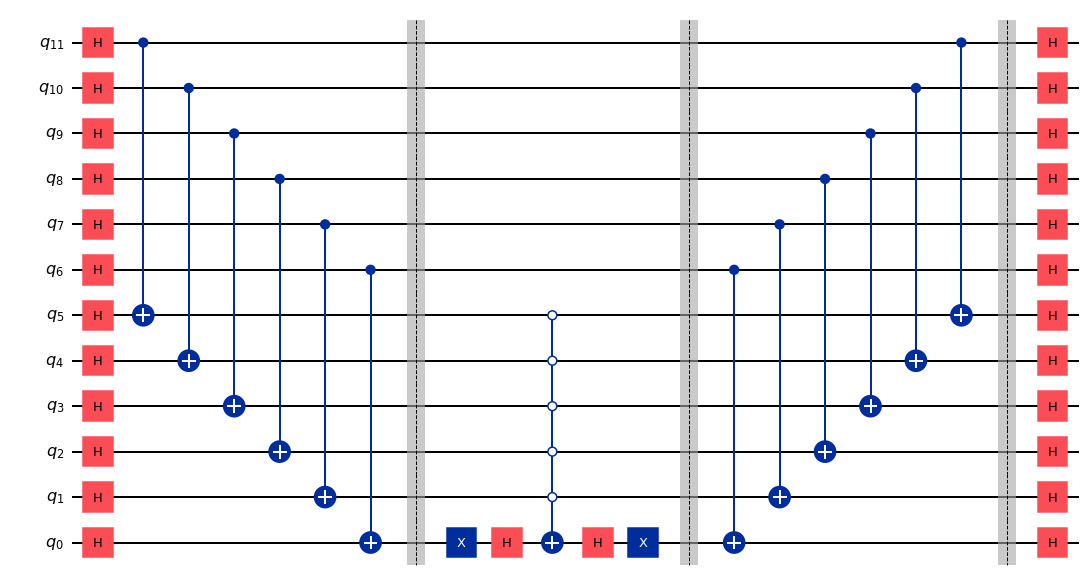

In [34]:
n = 6
G_u = get_G_X(n)

circ_gu = get_Gu_circuit(n)
circ_gu_matrix = qi.Operator.from_circuit(circ_gu).data.real 

G_u_rec = ((2**n)/2)*(np.eye(2**(2*n))-circ_gu_matrix)
print('n = {}'.format(n), norm(G_u - G_u_rec))

circ_gu.draw('mpl',style="iqp", reverse_bits=True)

In [35]:
n = 3
circ_gu = get_Gu_circuit(n)
circ_gu.draw('latex_source', style="iqp", reverse_bits=True, filename='./file.tex')
!pdflatex file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./file.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/standalone/standalone.cls
Document Class: standalone 2022/10/10 v1.3b Class to compile TeX sub-files stan
dalone
(/usr/local/texlive/2023/texmf-dist/tex/latex/tools/shellesc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifluatex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/xkeyval/xkeyval.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/xkeyval/xkeyval.tex
(/usr/local/texlive/2023/texmf-dist/tex/generic/xkeyval/xkvutils.tex
(/usr/local/texlive/2023/texmf-dist/tex/generic/xkeyval/keyval.tex))))
(/usr/local/texlive/2023/texmf-dist/tex/latex/standalone/standalone.cfg)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Docume

### Test circuit for $M = 2^k, k>2$

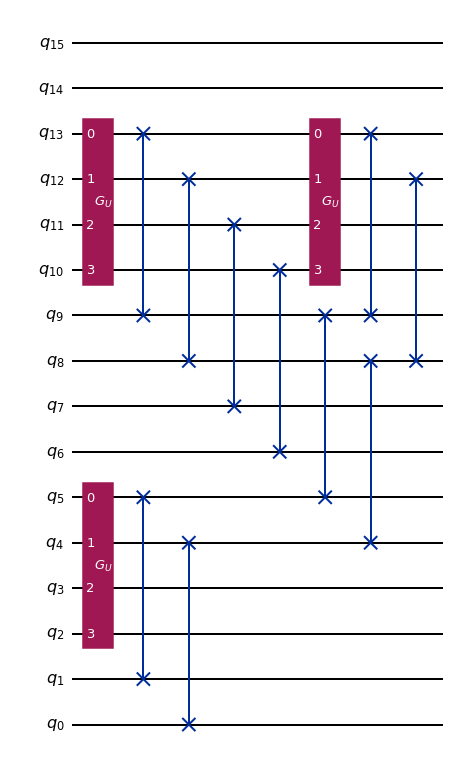

In [9]:
n = 2
N = 2**n
Gu = make_Gu(N)
Gu_op = qi.Operator(Gu)
k = 3
M_2 = 2**k


cir_test = get_circ_power_2(M_2, Gu_op, n)
cir_test = cir_test.reverse_bits()

cir_test.draw('mpl',style="iqp", reverse_bits=True)

### Test connect circuit

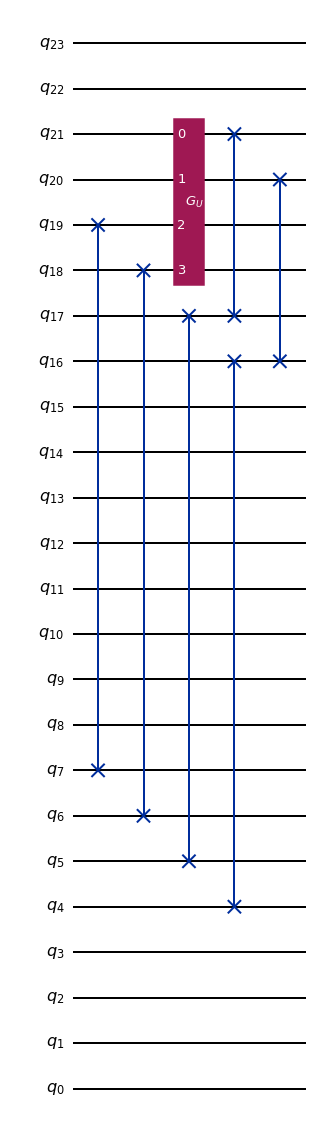

In [10]:
n = 2
N = 2**n
Gu = make_Gu(N)
Gu_op = qi.Operator(Gu)
M = 12

cir_test = get_circ_connect(M, Gu_op, n)
cir_test = cir_test.reverse_bits()

cir_test.draw('mpl',style="iqp", reverse_bits=True)

### Whole circuit

In [11]:
## Generate inital conditions
np.random.seed(1)
n = 1
N = 2**n
I = np.eye(N)
vec_I = I.reshape(-1,order='F')
M = 14
L = math.ceil(np.log2(M)) - 1 # number of layers
init_state = (1/N)**(M/4) * reduce(np.kron, [vec_I for i in range(M//2)])
U_list = []
for i in range(M):
    U = unitary_group.rvs(N)
    U_list.append(U)
    
Gu = make_Gu(N)
Gu_op = qi.Operator(Gu)

v = np.random.rand(N)
v = v/norm(v)
Vu = make_Vu(v)
Vu_op = qi.Operator(Vu)


exact_result = np.array(v)
for U in U_list[::-1]:
    exact_result = U@exact_result

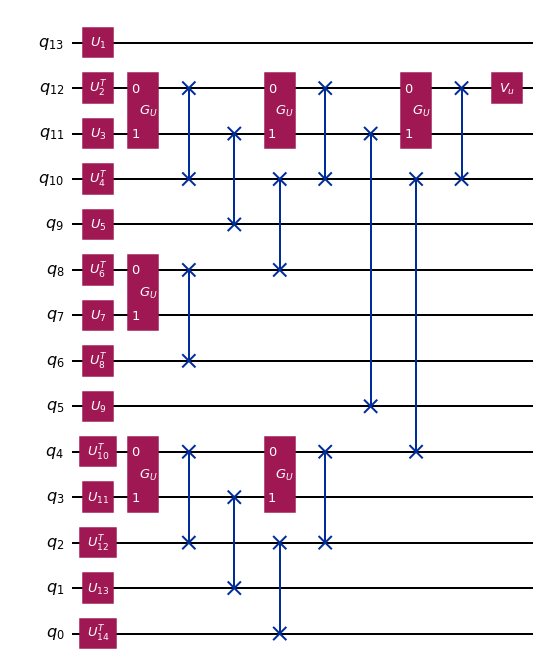

In [12]:
circ_full = get_full_circuit(M, n, U_list, Vu_op)
# circ_full.draw('mpl', style="iqp", reverse_bits=True).savefig('CircPar_n-{}_M-{}.png'.format(n,M))
circ_full.draw('mpl', style="iqp", reverse_bits=True)


# circ_full = get_full_circuit(M, n, U_list, Vu_op)
# circ_full.draw('latex_source', style="iqp", reverse_bits=True, filename='./file.tex')
# !pdflatex file.tex

In [13]:
state = Statevector(init_state)
state = state.evolve(circ_full)
circuit_data = state.data
A = np.sqrt(N)**(M-1) #initial=M/2 + num_g=M/2-1
circuit_data = A*circuit_data
result = [circuit_data[i*2**((M-1)*n)] for i in range(N)]
print(norm(result - exact_result))
# result/exact_result

4.665599982471358e-16


### Check different parameters

In [14]:
for M in [2*i for i in range(1,21)]:
    for n in range(1,3):
        ## Generate inital conditions
        np.random.seed(1)
#         n = 1
        N = 2**n
        I = np.eye(N)
        vec_I = I.reshape(-1,order='F')
    #     M = 4
        L = math.ceil(np.log2(M)) - 1 # number of layers
        init_state = (1/N)**(M/4) * reduce(np.kron, [vec_I for i in range(M//2)])
        U_list = []
        for i in range(M):
            U = unitary_group.rvs(N)
            U_list.append(U)

        Gu = make_Gu(N)
        Gu_op = qi.Operator(Gu)

        v = np.random.rand(N)
        v = v/norm(v)
        Vu = make_Vu(v)
        Vu_op = qi.Operator(Vu)


        exact_result = np.array(v)
        for U in U_list[::-1]:
            exact_result = U@exact_result


        ##############

        circ_full = get_full_circuit(M, n, U_list, Vu_op)

        ##############

        state = Statevector(init_state)
        state = state.evolve(circ_full)
        circuit_data = state.data
        A = np.sqrt(N)**(M-1) #initial=M/2 + num_g=M/2-1
        circuit_data = A*circuit_data
        result = [circuit_data[i*2**((M-1)*n)] for i in range(N)]

        print(M, n, norm(result - exact_result))

2 1 1.7451869960311208e-16
2 2 2.2771838694454674e-16
4 1 1.9229626863835638e-16
4 2 4.041272810440265e-16
6 1 4.75098925995612e-16
6 2 2.466969522362136e-16
8 1 5.382005793715205e-16
8 2 6.875109865312971e-16
10 1 4.236704743275018e-16
10 2 3.398508799723934e-16
12 1 3.8659043403122315e-16


KeyboardInterrupt: 

### Whole circuit with Gu as LSU

#### Matrix check

In [15]:
def get_Gu_LCU(n):
    '''n - is the size of one register'''
    Gu = np.zeros((2**(2*n), 2**(2*n)))
    for j in range(2**n):
        j_bin = format(j, '0{}b'.format(n))
        P = reduce(np.kron, [PAULIS['X'] if k == '1' else PAULIS['I'] for k in  j_bin])
        Gu += np.kron(P,P)
    return Gu


def get_Vu_LCU_diag(v):
    '''v is normolized vector of size 2^n'''
    N = len(v)
    n = int(np.log2(N))
    Vu = np.zeros((N,N))
    for j,vj in enumerate(v):
        j_bin = format(j, '0{}b'.format(n))
        P = reduce(np.kron, [PAULIS['Z'] if k == '1' else PAULIS['I'] for k in  j_bin])
        Vu += vj*P
    return Vu


def get_Vu_LCU(v):
    '''v is normolized vector of size 2^n'''
    N = len(v)
    n = int(np.log2(N))
    Vu = np.zeros((N,N))
    for j,vj in enumerate(v):
        j_bin = format(j, '0{}b'.format(n))
        P = reduce(np.kron, [PAULIS['X'] if k == '1' else PAULIS['I'] for k in  j_bin])
        Vu += vj*P
    return Vu

In [16]:
n = 1
N = 2**n
Gu_LCU = get_Gu_LCU(n)
Gu_LCU_expm = expm(1j*(np.pi/N)*Gu_LCU)


Gu_re = (N/2)*(np.eye(Gu_LCU.shape[0]) - Gu_LCU_expm)
print(norm(Gu_re - Gu_LCU))

4.505058141168416e-16


In [17]:
n = 5
N = 2**n
v = np.random.rand(N)
v = v/norm(v)

Vu_LCU_diag = get_Vu_LCU_diag(v)
norm_diag = np.max(abs(Vu_LCU_diag))
Vu_LCU_arc = np.diag(np.arccos(np.diag(Vu_LCU_diag)/norm_diag))


Vu_LCU_expm_1 = expm(1j*Vu_LCU_arc)
Vu_LCU_expm_2 = expm(-1j*Vu_LCU_arc)

Vu_re = (norm_diag/2)*(Vu_LCU_expm_1 + Vu_LCU_expm_2)
print(norm(Vu_re - Vu_LCU_diag))

3.1151568208829516e-15


#### Circuit check $G_u$

In [18]:
n = 2
N = 2**n
Gu_LCU = get_Gu_LCU(n)
Gu_LCU_expm = expm(1j*(np.pi/N)*Gu_LCU)

Gu_LCU_op = qi.Operator(-Gu_LCU_expm)
circ_Gu = QuantumCircuit(2*n)
circ_Gu.unitary(Gu_LCU_op, range(2*n), label = "Gu")
cGu_gate = circ_Gu.to_gate( label = "-exp(i pi Gu/N)").control(1, ctrl_state=0) # ctrl_state does not matter

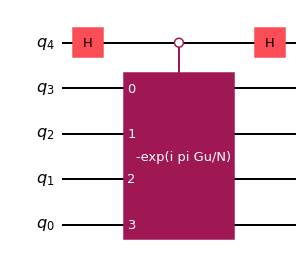

In [19]:
circ_test = QuantumCircuit(2*n + 1)
circ_test.h(0)
circ_test.append(cGu_gate, range(2*n + 1))
circ_test.h(0)

circ_test_rev = circ_test.reverse_bits()

circ_test_rev.draw('mpl', style="iqp", reverse_bits=True)

In [20]:
v = np.random.rand(2**(2*n))
v = v/norm(v)

init_state = np.kron(np.array([1,0]), v)
state = Statevector(init_state)
state = state.evolve(circ_test_rev)
circuit_data = state.data


A = N
circuit_data = A*circuit_data
result = circuit_data[:2**(2*n)]
print(norm(result - Gu_LCU@v))
# result/exact_result

2.3805503128172577e-14


#### Circuit check $V_u$

In [21]:
n = 3
N = 2**n
v = np.random.rand(N)
v = v/norm(v)
norm_diag = np.sum(abs(v))+0.1

Vu_LCU_diag = get_Vu_LCU_diag(v)
Vu_LCU_arc = np.diag(np.arccos(np.diag(Vu_LCU_diag)/norm_diag))
Vu_LCU_expm_1 = expm(1j*Vu_LCU_arc)
Vu_LCU_expm_2 = expm(-1j*Vu_LCU_arc)



Vu_LCU_expm_1_op = qi.Operator(Vu_LCU_expm_1)
circ = QuantumCircuit(n)
circ.unitary(Vu_LCU_expm_1_op, range(n), label = "Gu")
cVu_LCU_expm_1_op = circ.to_gate( label = "exp(i Varc)").control(1, ctrl_state=0)

Vu_LCU_expm_2_op = qi.Operator(Vu_LCU_expm_2)
circ = QuantumCircuit(n)
circ.unitary(Vu_LCU_expm_2_op, range(n), label = "Gu")
cVu_LCU_expm_2_op = circ.to_gate( label = "exp(-i Varc)").control(1, ctrl_state=1)

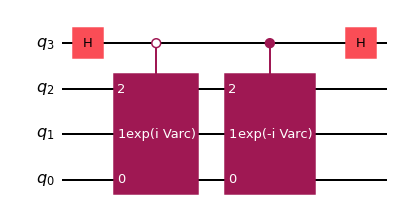

In [22]:
circ_test = QuantumCircuit(n+1)
circ_test.h(0)
circ_test.append(cVu_LCU_expm_1_op, [0]+list(range(1,n+1))[::-1])
circ_test.append(cVu_LCU_expm_2_op, [0]+list(range(1,n+1))[::-1])
circ_test.h(0)

circ_test_rev = circ_test.reverse_bits()

circ_test_rev.draw('mpl', style="iqp", reverse_bits=True)

In [23]:
w = np.random.rand(2**(n))
w = w/norm(w)

init_state = np.kron(np.array([1,0]), w)
state = Statevector(init_state)
state = state.evolve(circ_test_rev)
circuit_data = state.data

A = norm_diag
circuit_data = A*circuit_data
result = circuit_data[:2**(n)]
print(norm(result - Vu_LCU_diag@w))

3.821417832850155e-15
